# Assignment 2 - AI2

__Student's Credentials__: Vissarion Moutafis - sdi1800119

In this assignment we will try to create an effective ML pipeline that will get a raw sentence and will predict whether the sentence is pro-vaccine or anti-vaccine or neutral. The training corpus comes from twitter, as well as the evaluation dataset.

## Assignment 2 Addition
We will create several NNs and train them and after compare them with the softmax regression to meassure the perfomance improvement.

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn
import re

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, accuracy_score, confusion_matrix, recall_score, log_loss
from sklearn.decomposition import PCA
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, classification_report

import nltk
from nltk.stem.snowball import SnowballStemmer 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

seaborn.set_style("ticks")
nltk.download("stopwords")
nltk.download("wordnet")

import torch
from torchtext.data.utils import get_tokenizer
!pip install pytorch-ignite

from ignite.engine import Engine, Events
from ignite.handlers import EarlyStopping

!pip install tqdm
from tqdm import tqdm, trange

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
     |████████████████████████████████| 251 kB 3.7 MB/s 
cuda:0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# CHANGE THIS ONLY
dir_path = "/content/drive/MyDrive/Collab-Datasets/Vaccine Sentiment Dataset/"


In [4]:
train_dt_path = dir_path + "vs_train.csv"
test_dt_path = dir_path + "vs_dev.csv"

LABELS = ['neutral', 'anti-vax', 'pro-vax']

In [5]:
train_df_raw = pd.read_csv(train_dt_path, index_col=0)
test_df_raw = pd.read_csv(test_dt_path, index_col=0)

train_df_raw.head()

,tweet,label
0,Sip N Shop Come thru right now #Marjais #Popul...,0
1,I don't know about you but My family and I wil...,1
2,@MSignorile Immunizations should be mandatory....,2
3,President Obama spoke in favor of vaccination ...,0
4,"""@myfoxla: Arizona monitoring hundreds for mea...",0


In [6]:
# get test/test X and y
X_train_raw, y_train = train_df_raw["tweet"].to_numpy().reshape((-1,1)), train_df_raw["label"].to_numpy().reshape((-1,1))
X_test_raw, y_test = test_df_raw["tweet"].to_numpy().reshape((-1,1)), test_df_raw["label"].to_numpy().reshape((-1,1))

# Best Model from HW1

Here we will deploy the best performing model from the previous assignment

## Data Preprocessing and Feature Extraction

### Data Cleaning

Actions Taken to clean sentences:

- All to lower case
- Remove http(s):// since its useless
- Separate URL parts since there might be some hidden features there
- Remove specific stopwords
- Remove punctuation

In [7]:
sw = set([re.sub(r'[^\w\s]', '', w) for w in stopwords.words("english")]) - {"no", "yes", 'dont', 'didnt', 'wasnt', 'wont', 'will', 'not', 'can', 'cannot', 'should', 'shouldnt'}
lemmatizer = WordNetLemmatizer()

In [8]:
def clean_tweet(tweet):
  all_lower_s = str(tweet).lower().strip(' ').strip('\t') # all to lowercase
  no_http_s = re.sub(r'http://|https://', '', all_lower_s) # keep only the part after http(s), for space efficiency 
  no_http_s = re.sub(r'/', ' ', no_http_s) # separate domain from link ending
  no_punctuation_s = re.sub(r'[^\w\s]', '', no_http_s) # remove punctuation
  no_stopwords_s = ' '.join([w for w in no_punctuation_s.split() if not w in sw]) 
  
  return " ".join([lemmatizer.lemmatize(w, pos='v') for w in no_stopwords_s.split()])

def clean_tweets(X):
  return np.apply_along_axis(clean_tweet, 1, X)

In [9]:
# clean the tweets
cleaned_tweets = clean_tweets(X_train_raw)

### Feature Extraction w\ vectorizing

Now it's time to extract features and create a bug of words. For this task we will create a function to return the transformed encoded data so we can actually train the model. We could use 
- CountVectorizer
- HashVectorizer
- TF-IDF Transformer

We will also use a _PCA dimension reducer_ in order to get the most important features of the vector and a _StandardScaler_ to normalize the training instances before model training.

In [10]:
N_FEATURES = 2000         # number of features that the vectorizers will produce
N_FEATS_IMPORTANT = 400   # number of important features to keep after dimension reduction operation
N_GRAMS = (1,3)           # n-grams to consider
MAX_ITER = 500

Define vectorizer, the PCA reducer and the Standard Scaler

In [11]:
count_vectorizer = CountVectorizer(ngram_range=N_GRAMS, max_features=N_FEATURES, max_df=0.7)
count_vectorizer.fit(cleaned_tweets)

pca_count = PCA(n_components=N_FEATS_IMPORTANT)
pca_count.fit(count_vectorizer.transform(cleaned_tweets).toarray())

scaler_count = StandardScaler()

In [12]:
# simple function to transform tweets into a normalized feature matrix
def transform_tweets(X, vectorizer, reducer, scaler):
  new_X = reducer.transform(vectorizer.transform(X).toarray())
  from sklearn.utils.validation import check_is_fitted
  try:
    check_is_fitted(scaler)
  except:
    scaler.fit(new_X)
    print("Fitted Scaler")

  return scaler.transform(new_X)

## Softmax Regression Model

Train the softmax regression model for every vectorization method and fit the model according to $X_{train}$ 

In [13]:
model_count = LogisticRegression(n_jobs=-1, verbose=2, max_iter=MAX_ITER)
X_train_count = transform_tweets(cleaned_tweets, count_vectorizer, pca_count, scaler_count)



Fitted Scaler


In [14]:
model_count.fit(X_train_count, y_train.reshape((-1,)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   10.9s finished


LogisticRegression(max_iter=500, n_jobs=-1, verbose=2)


## Softmax Evaluation

Print statistics for each one of the model.

In [15]:
def get_stats(model, X, y):
  y_pred = model.predict(X)
  y_pred_proba = model.predict_proba(X)
  return accuracy_score(y, y_pred), precision_score(y, y_pred, labels=[0,1,2], average='weighted'), f1_score(y, y_pred, labels=[0,1,2], average='weighted'), recall_score(y, y_pred, labels=[0,1,2], average='weighted'), log_loss(y, y_pred_proba)

def print_stats(model, X, y):
  acc, pre, f, rec, loss = get_stats(model, X, y)

  print("Accuracy:", acc)
  print("Precision:", pre)
  print("Recall:", rec)
  print("F1-Score:", f)
  print("Cross Entropy Loss:", loss)

In [16]:
X_test_count = transform_tweets(clean_tweets(X_test_raw), count_vectorizer, pca_count, scaler_count)

print("Count Vectorizer Softmax Regression: ")
print_stats(model_count, X_test_count, y_test)

Count Vectorizer Softmax Regression: 
Accuracy: 0.7002629272567923
Precision: 0.6962932066792498
Recall: 0.7002629272567923
F1-Score: 0.6943740106055803
Cross Entropy Loss: 0.7090093821012559


# Pytorch NNs
We will create 4 separate Feed-Froward NN models, but first let's clean the datasets. 

We will use the same cleaning function as in homework 1, but we will define a new struct, DataLoader that batches the input. We will use the default dataloader from pytorch and overload the Dataset class.

### The Dataset Class

We will override the Dataset class of pytorch to supply the dataloaders with our own data.

In [17]:
train_tweets = clean_tweets(X_train_raw)
test_tweets = clean_tweets(X_test_raw)

In [18]:
class ClassifierDataset(torch.utils.data.Dataset):
  def __init__(self, X_data, y_data):
    self.X_data = X_data
    self.y_data = y_data
        
  def __getitem__(self, index):
    return self.X_data[index], self.y_data[index]
        
  def __len__ (self):
    return len(self.X_data)

### Feedforward NN Template

We provide a template to build NNs with various numbers of hidden layers and specific activation layers. There is always a batch normalization at the input layer and after each activation function. There is also a dropout layer after each activation.

We use those batch normalization and dropout layers in order to avoid overfitting.

In [60]:
class Feedforward(torch.nn.Module):
  def __init__(self, input_size, hidden_sizes, n_hidden_layers=1, activation=torch.nn.ReLU, verbose=False, n_classes=3, dropout_rate=0.4):
    super(Feedforward, self).__init__()
    # set up basic parameters
    self.input_size = input_size
    self.hidden_sizes  = hidden_sizes
    self.n_hidden_layers = n_hidden_layers
    self.verbose = verbose

    # set up input layer and input batch normalization layer
    if n_hidden_layers > 0:
      self.layers = torch.nn.ModuleList([torch.nn.Linear(self.input_size, self.hidden_sizes[0]).to(device)]) # add at least one hidden layer
      out_input_shape = self.hidden_sizes[-1]
    else:
      out_input_shape = self.input_size

    self.batchesNorm = torch.nn.ModuleList([torch.nn.BatchNorm1d(self.input_size, device=device).to(device)])
    
    # create a list of layers in order to provide the caller with dynamic layer architecture 
    if n_hidden_layers > 0:
      prev_hid_size = hidden_sizes[0]
    for i in range(1, n_hidden_layers):
      # the __to_device()__ calls are necessary since the list's layers will not be translated to gpu otherwise
      self.batchesNorm.append(torch.nn.BatchNorm1d(prev_hid_size, device=device).to(device))
      self.layers.append(torch.nn.Linear(prev_hid_size, self.hidden_sizes[i]).to(device))
      prev_hid_size = self.hidden_sizes[i]

    # add the final batch normalization before the exit layer
    if n_hidden_layers > 0:
      self.batchesNorm.append(torch.nn.BatchNorm1d(prev_hid_size, device=device).to(device))

    # set up activation
    self.activation = activation()
    # set up dropout layer
    self.dropout = torch.nn.Dropout(p=dropout_rate)
    self.output_logits = torch.nn.Linear(out_input_shape, n_classes)

  # default forward call to pass input through each layer, activation, batch normalization and dropout, according to layer list 
  def forward(self, x):
    # translate input to device
    inpt = x.to(device)
    out = inpt
    
    # apply batcNorm, dense layer, activation, dropout cur-off for every layer in the layer list
    for i in range(self.n_hidden_layers):
      hidden = self.layers[i](self.batchesNorm[i](inpt))
      out = self.activation(hidden)
      inpt = self.dropout(out)

    #  return the output of the NN
    output = self.output_logits(self.batchesNorm[-1](out))
    return output
  

  def trainning_step(self, optimizer, criterion, epoch_i, train_loader, eval_loader, history=None):
    global device

    # 1 step of backprop with train/test error estimation
    total_loss = 0
    for _X, _y in train_loader:
      X, y = _X.to(device), _y.to(device)
      # set the gradients to zero for new estimation
      optimizer.zero_grad() 
      # forward pass
      y_pred = self(X)
      # compute loss 
      loss = criterion(y_pred, y)
      total_loss += loss.item()

      # backpropagate error
      loss.backward()
      # adjust model's parameters
      optimizer.step()

    train_loss = total_loss/len(train_loader)
    total_loss = 0

    with torch.no_grad():
      for _X, _y in eval_loader:
        X, y = _X.to(device), _y.to(device)
        y_pred = self(X)
        loss = criterion(y_pred, y)
        total_loss += loss.item()

    test_loss = total_loss/len(eval_loader)

    # if the user provides with a history dict the training step will save the current epoch's train-test loss
    if history is not None: 
      history['train'].append(train_loss)
      history['test'].append(test_loss)

    if self.verbose:
        print('Epoch {}: train loss: {}, test_loss: {}'.format(epoch_i, train_loss, test_loss))    # Backward pass
    
    return train_loss, test_loss

### Bow Models
The first model will use the BoW vectorizer of previous Assignment
We make sure that the model can have at least 1 layer and an output layer. The hiden layer number and sized can be given by the user, so we can define various number of dense layers.

__Loss Function__ : Cross Entropy  Loss (proper for multi class problems)

__Optimizer__: Stohastic Gradient Descent, Adam, etc.

#### Model 1

Simple architecture of 2 hidden layers $512 \times 1024$ and $SELU$ activation.

In [61]:
X_train_1 = torch.from_numpy(transform_tweets(train_tweets, count_vectorizer, pca_count, scaler_count)).float()
D_train_1 = ClassifierDataset(X_train_1, y_train[:, 0])
train_loader_1 = torch.utils.data.DataLoader(D_train_1, batch_size=512) 

X_test_1 = torch.from_numpy(transform_tweets(test_tweets, count_vectorizer, pca_count, scaler_count)).float()
D_test_1 = ClassifierDataset(X_test_1, y_test[:, 0])
test_loader_1 = torch.utils.data.DataLoader(D_test_1, batch_size=X_test_1.shape[0])

In [62]:
model1 = Feedforward(X_train_1.shape[1], [], n_hidden_layers=0, dropout_rate=0.7)
model1.to(device)
history1 = {'train':[], 'test':[]}

In [63]:
# set to training mode
model1.train()
criterion = torch.nn.CrossEntropyLoss()
_lr = 0.001
optimizer = torch.optim.Adam(model1.parameters(), lr = _lr)

pbar = tqdm(range(100))
for epoch in pbar:
  train_loss, test_loss = model1.trainning_step(optimizer, criterion, epoch, train_loader_1, test_loader_1, history1)
  pbar.set_description('Epoch {}: train loss: {}, test_loss: {}'.format(epoch, train_loss, test_loss), refresh=True)

Epoch 99: train loss: 0.674605855718255, test_loss: 0.7076307535171509: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


#### Model 2

Architevture of Shallow NN: 1 hiden layer of $1024$ nodes with $SELU$ activation.

In [112]:
model2 = Feedforward(X_train_1.shape[1], [1024], n_hidden_layers=1, activation=torch.nn.LeakyReLU)
model2.to(device)
history2 = {'train':[], 'test':[]}

In [113]:
# set to training mode
model2.train()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr = 0.0001)

pbar = tqdm(range(10))
for epoch in pbar:
  train_loss, test_loss = model2.trainning_step(optimizer, criterion, epoch, train_loader_1, test_loader_1, history2)
  pbar.set_description('Epoch {}: train loss: {}, test_loss: {}'.format(epoch, train_loss, test_loss), refresh=True)

Epoch 9: train loss: 0.551493120379746, test_loss: 0.7349151372909546: 100%|██████████| 10/10 [00:02<00:00,  3.81it/s]


### NNs with GLoVe Embeddings

We will use the following cells to download and load the embeddings files

In [74]:
# set up dir of glove embeddings or uncomment the following 2 lines to download
dir_glove = 'drive/MyDrive/Collab-Datasets/'
# !wget nlp.stanford.edu/data/wordvecs/glove.6B.zip
# !unzip glove.6B.zip
# !ls -l

Following, we will parse the embeddings file. Use the N_EMBEDDINGS to choose the numbers of embeddings dimensions.


In [75]:
def parse_line(line) :
  line_split = line.split()
  word = clean_tweet(line_split[0])
  vec = np.asarray(line_split[1:], dtype=np.float64)
  return word, vec

# create vocabulary of pro/neutral/anti vax
def create_vocab(tweets, labels) :
  v = set()
  for tweet, label in zip(tweets, labels):
    for tok in tweet.split():
      v.add(tok)      
  return v

In [76]:
N_EMBEDDINGS = 200
# create a word_idx to embedding dict and a tokenizer dict
word_emb = {'<unknown>': np.zeros((N_EMBEDDINGS,))}
word2idx = {'<unknown>':0}
idx = 1

with open(dir_glove + f"glove.6B.{N_EMBEDDINGS}d.txt") as embeddings_file:
  for line in embeddings_file.readlines():
    word, vec = parse_line(line)
    word_emb[word] = vec

Now we have to create a word2idx and a vocabulary so that we construct the initial embeddings layer, using pytorch's template

In [77]:
# create weight matrix for word embeddings
def create_W(target_vocab, word2emb, n_features):
  global idx

  # concat all words from all vocabularies and init the weight matrix
  W = np.zeros((len(target_vocab)+1, n_features))

#  parse all the words and create the respective embedding weights
  for i, w in enumerate(target_vocab):
    #  add the word in the indexing table
    word2idx[w] = idx 
    idx += 1

    # consider the importance of the embedding
    try:
      W[i+1] = word2emb[w]
    except KeyError:
      W[i+1] = np.random.normal(scale=0.6, size=(n_features,))
  return W

# Now we must define a function to create an embeedings layer
def create_embedding_layer(weights, trainable=True):
  num_embeddings, embeddings_dim = weights.shape
  emb_layer = torch.nn.Embedding(num_embeddings, embeddings_dim).to(device)
  emb_layer.load_state_dict({'weight' : torch.from_numpy(weights).float()})
  emb_layer.weight.requires_grad = trainable
  return emb_layer


In [78]:
idx = 1
train_tweets_vocab = create_vocab(train_tweets, y_train)

In [79]:
train_weights = create_W(train_tweets_vocab, word_emb, N_EMBEDDINGS)

In [80]:
def tweet2ids(tweet, id_map):
  ids = []
  for w in tweet.split():
    if w in id_map:
      ids.append(id_map[w])
    else:
      ids.append(id_map['<unknown>'])

  return ids if len(ids) else [0]

def tweet2embedding(tweet, embedding_layer):
  return embedding_layer(torch.LongTensor(tweet2ids(tweet, word2idx)).to(device)).mean(axis=0)

### FeedForward with Embeddings Template Class

Following we provide the user with a template to create his own NN with embeddings by just providing basic parameters and an embeddings layer

In [81]:
class FeedforwardwEmbeddings(Feedforward):
  def __init__(self, embeddings, input_size, hidden_sizes, n_hidden_layers=1, activation=torch.nn.ReLU, verbose=False):
    super(FeedforwardwEmbeddings, self).__init__(input_size, hidden_sizes, n_hidden_layers, activation, verbose)
    self.embeddings = embeddings
    self.input_size = input_size
    self.hidden_sizes  = hidden_sizes
    self.n_hidden_layers = n_hidden_layers
    self.verbose = verbose
    self.inpt = None
    self.in_eval = False 

  def toEmbeddings(self, tweets):
    return torch.stack([
                        tweet2embedding(x_i, self.embeddings) for x_i in tweets
    ])


#### Model 1 w Embeddings

Shallow NN with 3 hidden layer of $1024$ nodes and $ReLU$ activation. 

In [82]:
embedding_layer = create_embedding_layer(train_weights, False)

In [116]:
model_emb1 = FeedforwardwEmbeddings(embedding_layer, N_EMBEDDINGS, [1024, 1024, 1024], n_hidden_layers=3, activation=torch.nn.ReLU)
model_emb1.to(device)

history3={'train':[], 'test':[]}


In [84]:
D_train_2 = ClassifierDataset(model_emb1.toEmbeddings(train_tweets), y_train[:, 0])
train_loader_2 = torch.utils.data.DataLoader(D_train_2, batch_size=512)

D_test_2 = ClassifierDataset(model_emb1.toEmbeddings(test_tweets), y_test[:, 0])
test_loader_2 = torch.utils.data.DataLoader(D_test_2, batch_size=512)


In [117]:
# set to training mode
model_emb1.train()
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model_emb1.parameters(), lr = 0.003)

pbar = tqdm(range(200))
for epoch in pbar:
  train_loss, test_loss = model_emb1.trainning_step(optimizer, criterion, epoch, train_loader_2, test_loader_2, history3)
  pbar.set_description('Epoch {}: train loss: {}, test_loss: {}'.format(epoch, train_loss, test_loss), refresh=True)

Epoch 199: train loss: 0.7255320325493813, test_loss: 0.7834700107574463: 100%|██████████| 200/200 [00:52<00:00,  3.83it/s]


#### Model 2
Last model has 2 hidden layers with $200 \times 200$ total nodes and $LeakyReLU$ activation.

In [122]:
model_emb2 = FeedforwardwEmbeddings(embedding_layer, N_EMBEDDINGS, [200, 200], n_hidden_layers=2, activation=torch.nn.LeakyReLU)
model_emb2.to(device)

history4={'train':[], 'test':[]}

In [123]:
# set to training mode
model_emb2.train()
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_emb2.parameters(), lr = 0.0001)

pbar = tqdm(range(100))
for epoch in pbar:
  train_loss, test_loss = model_emb2.trainning_step(optimizer, criterion, epoch, train_loader_2, test_loader_2, history4)
  pbar.set_description('Epoch {}: train loss: {}, test_loss: {}'.format(epoch, train_loss, test_loss), refresh=True)

Epoch 99: train loss: 0.5138290105387568, test_loss: 0.807027268409729: 100%|██████████| 100/100 [00:23<00:00,  4.28it/s]


## Evaluation

We proceed by evaluating the models with f1-score, recall, precision.

### F1-Score, Precision, Recall

In [124]:
def print_stats(model, X, y):
  softmax = torch.nn.Softmax(dim=1).to(device)
  y_pred_proba = softmax(model(X)).detach().cpu().numpy()
  y_pred = y_pred_proba.argmax(axis=1).reshape((-1, 1))
  print(classification_report(y, y_pred, target_names=['neutral', 'anti-vax', 'pro-vax']))

#### Model 1 w\ BoW

In [125]:
print("Model1 w\out embeddings:")
model1.eval()
print_stats(model1, X_test_1, y_test)

Model1 w\out embeddings:
              precision    recall  f1-score   support

     neutral       0.76      0.77      0.76      1065
    anti-vax       0.57      0.35      0.43       296
     pro-vax       0.66      0.72      0.69       921

    accuracy                           0.70      2282
   macro avg       0.66      0.61      0.63      2282
weighted avg       0.69      0.70      0.69      2282



#### Model 2 w\ BoW

In [126]:
print("Model2 w\out embeddings:")
model2.eval()
print_stats(model2, X_test_1, y_test)

Model2 w\out embeddings:
              precision    recall  f1-score   support

     neutral       0.77      0.75      0.76      1065
    anti-vax       0.52      0.39      0.45       296
     pro-vax       0.65      0.72      0.68       921

    accuracy                           0.69      2282
   macro avg       0.65      0.62      0.63      2282
weighted avg       0.69      0.69      0.69      2282



#### Model 1 w\ Embeddings

In [127]:
print("Model1 w\ embeddings:")
model_emb1.eval()
print_stats(model_emb1, model_emb1.toEmbeddings(test_tweets), y_test)

Model1 w\ embeddings:
              precision    recall  f1-score   support

     neutral       0.83      0.61      0.70      1065
    anti-vax       0.57      0.23      0.33       296
     pro-vax       0.57      0.85      0.68       921

    accuracy                           0.66      2282
   macro avg       0.66      0.56      0.57      2282
weighted avg       0.69      0.66      0.65      2282



#### Model 2 w\ Embeddings

In [128]:
print("Model2 w\ embeddings:")
model_emb2.eval()
print_stats(model_emb2, model_emb2.toEmbeddings(test_tweets), y_test)

Model2 w\ embeddings:
              precision    recall  f1-score   support

     neutral       0.78      0.72      0.75      1065
    anti-vax       0.59      0.30      0.40       296
     pro-vax       0.62      0.77      0.68       921

    accuracy                           0.68      2282
   macro avg       0.66      0.60      0.61      2282
weighted avg       0.69      0.68      0.68      2282



### Loss vs Epochs

We will display the Loss vs Epochs-Curves for all of our models. For Explaination and Results check README.pdf

In [129]:
#printing loss curves

def graph_loss(history, ax):
  # we will print the error vs epoch plot 
  train_loss = history['train']
  test_loss = history['test']
  epochs = np.arange(len(train_loss))
  
  #train loss vs epochs
  ax.plot(epochs, train_loss, epochs, test_loss, 'orange')
  ax.set_xlabel('Epochs')
  ax.set_ylabel('Cross Entropy Loss')
  plt.legend(["Train", "Test"])



#### Model 1 w\ BoW

Text(0.5, 1.0, 'Loss vs Epochs for model 1')

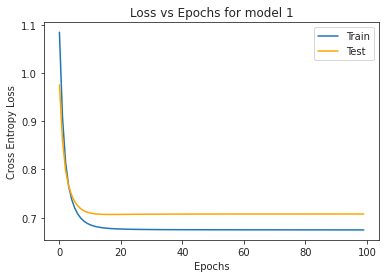

In [130]:
fig, ax = plt.subplots(1, 1)
graph_loss(history1, ax)
ax.set_title("Loss vs Epochs for model 1")


#### Model 2 w\ BoW

Text(0.5, 1.0, 'Loss vs Epochs for model 2')

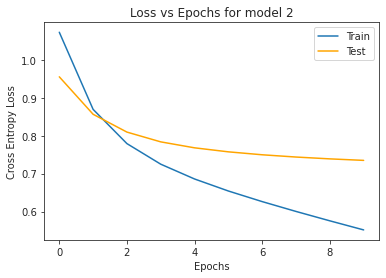

In [131]:
fig, ax = plt.subplots(1, 1)
graph_loss(history2, ax)
ax.set_title("Loss vs Epochs for model 2")

#### Model 1 w\ Embeddings

Text(0.5, 1.0, 'Loss vs Epochs for model w\\ embeddings 1')

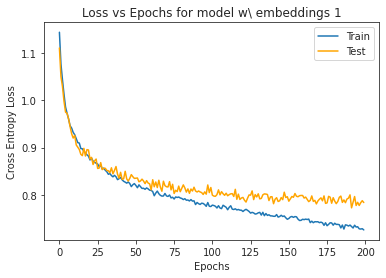

In [132]:
fig, ax = plt.subplots(1, 1)
graph_loss(history3, ax)
ax.set_title("Loss vs Epochs for model w\ embeddings 1")

#### Model 2 w\ Embeddings

Text(0.5, 1.0, 'Loss vs Epochs for model w\\ embeddings 2')

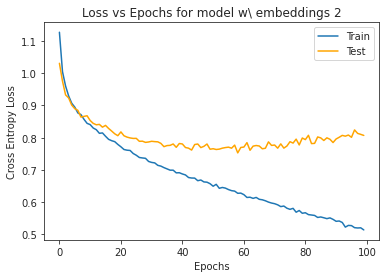

In [133]:
fig, ax = plt.subplots(1, 1)
graph_loss(history4, ax)
ax.set_title("Loss vs Epochs for model w\ embeddings 2")

### ROC Curves

Finaly we will display the ROC-Curves to explain our models predictive power. For extra notes on ROC-Curves check README.pdf

In [134]:
def graph_roc(model, X, y_test, n_classes=3):
  from sklearn.metrics import auc
  try:
    softmax = torch.nn.Softmax(dim=1).to(device)
    y_score = softmax(model(X)).detach().cpu().numpy()
  except:
    y_score = model.predict_proba(X)
    
  print(y_test.size)
  y_test_one_hot = np.zeros((y_test.size, n_classes), dtype=np.int8)
  y_test_one_hot[np.arange(y_test.size), y_test.reshape(-1)] = 1
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  graph_args = []

  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_score[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  fig, ax = plt.subplots(1, 1, figsize=(7, 5))
  ax.plot(fpr[0], tpr[0], fpr[1], tpr[1], 'orange', fpr[2], tpr[2], 'aqua', np.arange(0,2,0.2), np.arange(0,2,0.2), '--k')
  ax.legend([
             f"ROC-Class 'Neutral' (area = {np.round(roc_auc[0], 3)})",
             f"ROC-Class 'Anti-Vax' (area = {np.round(roc_auc[1], 3)})",
             f"ROC-Class 'Pro-Vax' (area = {np.round(roc_auc[2], 3)})"
  ])
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])

#### Model 1 w\ BoW

2282


Text(0.5, 1.0, 'ROC for model 1')

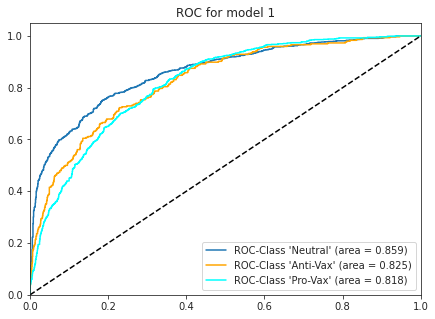

In [135]:
graph_roc(model1, X_test_1, y_test)
plt.title("ROC for model 1")

#### Model 2 w\ BoW

2282


Text(0.5, 1.0, 'ROC for model 2')

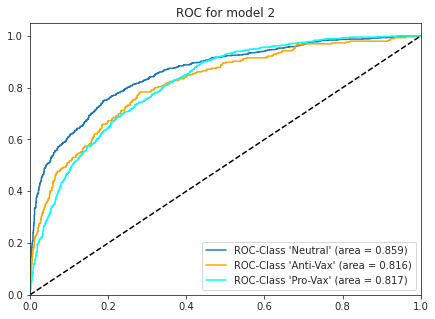

In [136]:
graph_roc(model2, X_test_1, y_test)
plt.title("ROC for model 2")

#### Model 1 w\ Embeddings

2282


Text(0.5, 1.0, 'ROC for model w\\ embeddings 1')

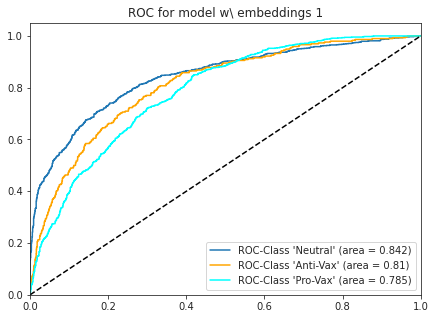

In [137]:
graph_roc(model_emb1, model_emb1.toEmbeddings(test_tweets), y_test)
plt.title("ROC for model w\ embeddings 1")

#### Model 2 w\ Embeddings

2282


Text(0.5, 1.0, 'ROC for model w\\ embeddings 2')

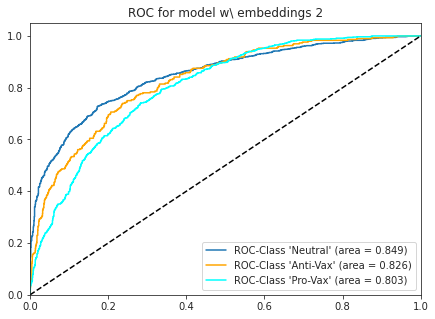

In [138]:
graph_roc(model_emb2, model_emb2.toEmbeddings(test_tweets), y_test)
plt.title("ROC for model w\ embeddings 2")

#### Softmax model

2282


Text(0.5, 1.0, 'ROC for Softmax model')

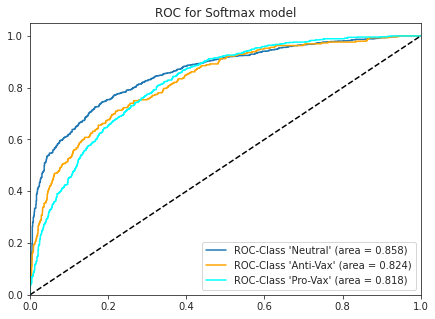

In [139]:
graph_roc(model_count, X_test_count, y_test)
plt.title("ROC for Softmax model")

### Notes

As we can see from the overall evaluation all 4 models are quite sensitive to perturbations around tweets of class "anti-vax" and that is realized when we study the classification report results where precision and recall are quite low, while f1-score is of the lowest among 3 classes. 

Furthermore, we can see that we cannot hit higher scores with embedding models, which perform a little worse than BoW models. This happens because we don't consider the 'time'-context of the embeddings apearance and only trying to aggregate a result, where some of them might skew the resulting vector toward a wrong direction, resulting in instance misclassification.

By studing the learning curves we can see that most models fit correctly without over/under - fit problems and this fact also supports our prior conclusion, that the models aren't complex enough (even when using word embeddings) to overcome the classification thresholds we observed.